# Проверка статистических гипотез.

По результатам разведочного анализа были выдвинуты следующие гипотезы:
1. Заработная плата зависит от территории
2. Зарплата зависит от работодателя
3. Зарплата зависит от типа профессии
4. Занятость влияет на зарплату
5. Зарплата зависит от опыта работы



In [1]:
!gdown --id 1XI_UhX4gRct5nSVC5dWKE_4LT1LKX9Jp
!gdown --id 1Yf7Dq8yHoMHDSuDet92iHMGKY7pEQxfH

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XI_UhX4gRct5nSVC5dWKE_4LT1LKX9Jp
To: /content/Датасет.csv
100% 537k/537k [00:00<00:00, 21.5MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Yf7Dq8yHoMHDSuDet92iHMGKY7pEQxfH
To: /content/Датасет разбитый.csv
100% 1.62M/1.62M [00:00<00:00, 252MB/s]


In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Датасет.csv')

Описательные статистики датасета

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3137 non-null   int64  
 1   name                3137 non-null   object 
 2   type                3137 non-null   int64  
 3   area                3137 non-null   object 
 4   salary              3137 non-null   float64
 5   employer            3137 non-null   object 
 6   professional_roles  3137 non-null   object 
 7   experience          3137 non-null   int64  
 8   employment          3137 non-null   int64  
 9   snippet             3137 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 245.2+ KB


In [5]:
df[['salary','experience']].describe()

,salary,experience
count,3137.000000,3137.000000
mean,87094.380618,1.372649
std,70433.979699,1.230637
min,12000.000000,0.000000
25%,40000.000000,1.000000
50%,64000.000000,1.000000
75%,100000.000000,1.000000
max,800000.000000,6.000000


## Проверка нормальности распределения зарплат

Text(0, 0.5, 'Количество вакансий')

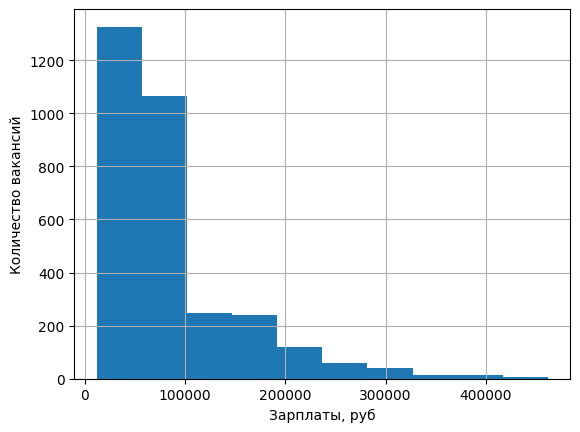

In [42]:
df[df['salary']<500000]['salary'].hist()
plt.xlabel('Зарплаты, руб')
plt.ylabel('Количество вакансий')

In [7]:
stats.shapiro(df['salary'])

ShapiroResult(statistic=0.7573361992835999, pvalue=0.0)

Отвергаем нулевую гипотезу о нормальности распределения, поскольку p-value < 0.05

## Проверка нормальности распределения опыта

Text(0, 0.5, 'Количество вакансий')

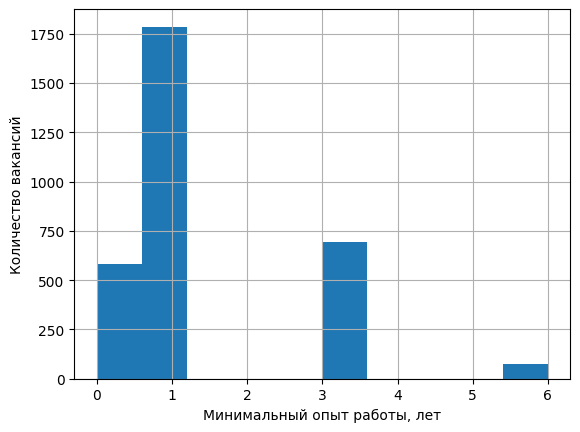

In [44]:
df['experience'].hist()
plt.xlabel('Минимальный опыт работы, лет')
plt.ylabel('Количество вакансий')

In [9]:
stats.shapiro(df['experience'])

ShapiroResult(statistic=0.7436321973800659, pvalue=0.0)

Отвергаем нулевую гипотезу о нормальности распределения данных об опыте

# Анализ влияния категориальных признаков на количественные показатели

## Зарплата-занятость

In [10]:
df.groupby('employment')['salary'].mean()

employment
1    89185.991090
2    61706.435644
3    33556.338028
4    92670.212766
Name: salary, dtype: float64

Text(0, 0.5, 'Зарплаты, руб')

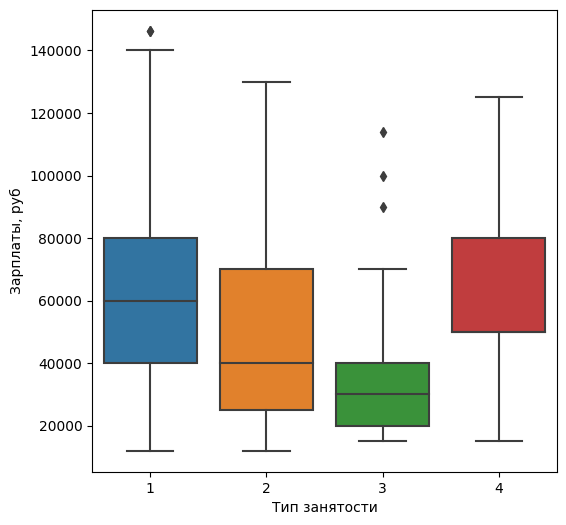

In [46]:
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x='employment', y='salary', data=df[df['salary'] < 150000])
plt.xlabel('Тип занятости')
plt.ylabel('Зарплаты, руб')

In [12]:
df1 = df[df['salary'] < 150000]
df_e1 = np.array(df1[df1['employment'] == 1]['salary'])
df_e2 = np.array(df1[df1['employment'] == 2]['salary'])
df_e3 = np.array(df1[df1['employment'] == 3]['salary'])
df_e4 = np.array(df1[df1['employment'] == 4]['salary'])
print(stats.shapiro(df_e1))
print(stats.shapiro(df_e2))
print(stats.shapiro(df_e3))
print(stats.shapiro(df_e4))

ShapiroResult(statistic=0.9381089210510254, pvalue=9.917305414723642e-31)
ShapiroResult(statistic=0.8987753391265869, pvalue=2.8774511520168744e-06)
ShapiroResult(statistic=0.7692776918411255, pvalue=3.3207714356109364e-09)
ShapiroResult(statistic=0.9555196166038513, pvalue=0.10945918411016464)


Гипотеза о нормальности групп отклоняется

In [13]:
stats.mstats.kruskalwallis(df_e1, df_e2, df_e3, df_e4)

KruskalResult(statistic=121.12114654448015, pvalue=4.4255728241567446e-26)

Согласно критерию Краскала-Уоллиса, отклоняем нулевую гипотезу о статистической незначимости отличий в группах. Таким образом, тип занятости влияет на зарплату

## Зарплата-территория

In [14]:
cities = df['area'].unique()
change = {}
i = 1
for city in cities:
    change[city] = i
    i+=1
col = {'area_new': change}

In [15]:
df1 = df.copy()
df1['area_new'] = df1['area']
df1 = df1.replace(col)

In [16]:
p_val = {}
for j in range(1, 150):
    try:
        p_val[j] = stats.shapiro(df1[df1['area_new']==j]['salary']).pvalue
    except:
        p_val[j] = 0
print(p_val)    

{1: 0.14764398336410522, 2: 3.513424720822448e-31, 3: 0.0012195997405797243, 4: 2.425286038487684e-05, 5: 3.5556939110392705e-05, 6: 4.986972726328531e-06, 7: 0, 8: 4.987504667042231e-07, 9: 5.079961283627199e-06, 10: 9.665720313023485e-08, 11: 0.0004701451980508864, 12: 3.193223818231114e-27, 13: 8.49302887218073e-05, 14: 0.005340720992535353, 15: 4.6467880565614905e-06, 16: 2.591809334262507e-06, 17: 8.574143062212158e-10, 18: 8.015113905912585e-09, 19: 1.3783655958832242e-05, 20: 0.0559314526617527, 21: 5.881005904484482e-09, 22: 0.011565707623958588, 23: 3.3068572520278394e-05, 24: 2.6177544896199834e-06, 25: 0.05092494189739227, 26: 0.0001405297953169793, 27: 0.0001956475171027705, 28: 6.5373983488825615e-06, 29: 2.7662051138577226e-07, 30: 0.009233081713318825, 31: 0.07531190663576126, 32: 0.546826958656311, 33: 0, 34: 0.000713520625140518, 35: 0.00010258440306643024, 36: 0.24131059646606445, 37: 0.0014501387486234307, 38: 0.12688729166984558, 39: 0.0011074491776525974, 40: 0, 41

Данные о зарплатах в городах не распределены по нормальному закону

In [17]:
groups = []
for j in range(1, 150):
    groups.append(np.array(df1[df1['area_new']==j]['salary']))
    

In [18]:
stats.mstats.kruskalwallis(*groups)

KruskalResult(statistic=726.5459203826464, pvalue=3.7697029134934075e-77)

Гипотезу о незначимости территории отвергаем, поскольку p-value крайне мало

## Зарплата-профессия

In [19]:
profs = df['professional_roles'].unique()
change1 = {}
i = 1
for prof in profs:
    change1[prof] = i
    i+=1
col['professional_roles_new'] = change1

In [20]:
df1['professional_roles_new'] = df1['professional_roles']
df1 = df1.replace(col)

In [21]:
p_val = {}
for j in range(1, len(profs)):
    try:
        p_val[j] = stats.shapiro(df1[df1['professional_roles_new']==j]['salary']).pvalue
    except:
        p_val[j] = 0
print(p_val) 

{1: 2.5255418985600074e-33, 2: 1.77471331589553e-18, 3: 6.801199312621783e-32, 4: 1.0887369835971966e-13, 5: 1.8417320619967814e-12, 6: 4.752768359130239e-15, 7: 0.0009953847620636225, 8: 7.350375199166592e-06, 9: 7.259653102664743e-06, 10: 5.781073952881854e-10, 11: 4.821615220862441e-05, 12: 0, 13: 0, 14: 0}


Хоть в некоторых группах данные о зарплатах распределены нормально, тем не менее гипотезу о нормальности групп принять нельзя.

In [22]:
groups = []
for j in range(1, len(profs)):
    groups.append(np.array(df1[df1['professional_roles_new']==j]['salary']))
stats.mstats.kruskalwallis(*groups)

KruskalResult(statistic=614.9927838222669, pvalue=4.872218092747284e-123)

Аналогично отклоняется гипотеза о незначимости признака "профессия" на целевой признак "зарплата"

## Зарплата-работодатель

In [23]:
emplrs = df['employer'].unique()
change2 = {}
i = 1
for emplr in emplrs:
    change2[emplr] = i
    i+=1
col['employer_new'] = change2
len(emplrs)

2507

In [24]:
df1['employer_new'] = df1['employer']
df1 = df1.replace(col)

In [25]:
counts = df1.groupby('employer_new')['salary'].count()

In [26]:
p_val = {}
for j in range(1, len(emplrs)):
    if counts[j] > 20:
        p_val[j] = stats.shapiro(df1[df1['employer_new']==j]['salary']).pvalue

print(p_val) 

{9: 2.1239457055344246e-06}


На первый взгляд, данные распределены в группах по большей части нормально, однако это связано с тем, что при обработке данных не указанные зарплаты в датасете были заменены на средние значения зарплат. В связи с этим в вакансиях у тех работадателей, которые не указывали зарплаты, все зарпалты были заменены на одно и то же значение.   

In [27]:
groups = []
for j in range(1, len(emplrs)):
    groups.append(np.array(df1[df1['employer_new']==j]['salary']))
stats.mstats.kruskalwallis(*groups)

KruskalResult(statistic=2898.6325140862346, pvalue=5.6849836017645175e-08)

Гипотеза о незначимости признака "работодатель" на целевой признак "зарплата" отвергается.

##Зарплата-опыт

Проверим нормальность распределения зарплат по опыту

<Axes: >

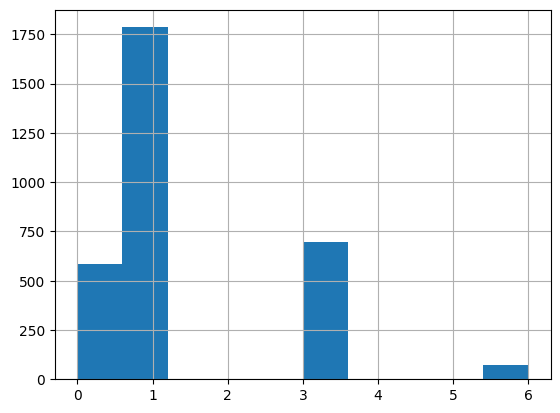

In [28]:
df['experience'].hist()

Text(37.722222222222214, 0.5, 'Зарплаты, руб')

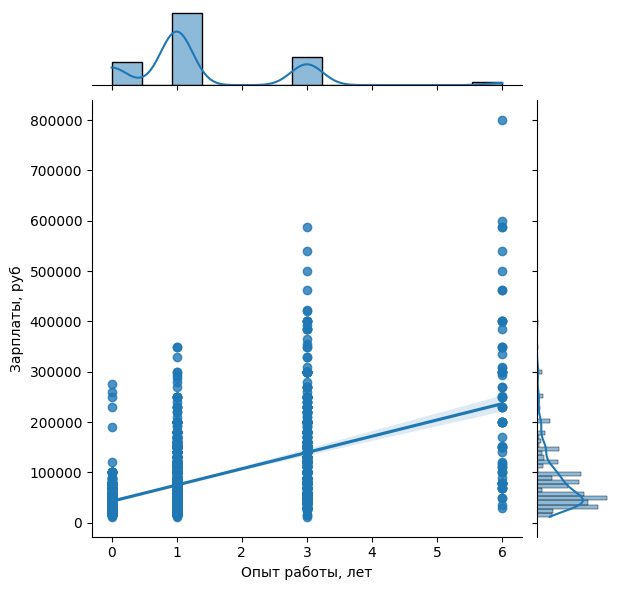

In [47]:
sns.jointplot(data=df, x='experience', y='salary',  kind='reg')
plt.xlabel('Опыт работы, лет')
plt.ylabel('Зарплаты, руб')

# Анализ связи между признаками

## Количественный и порядковый признак

### Зарплата-занятость

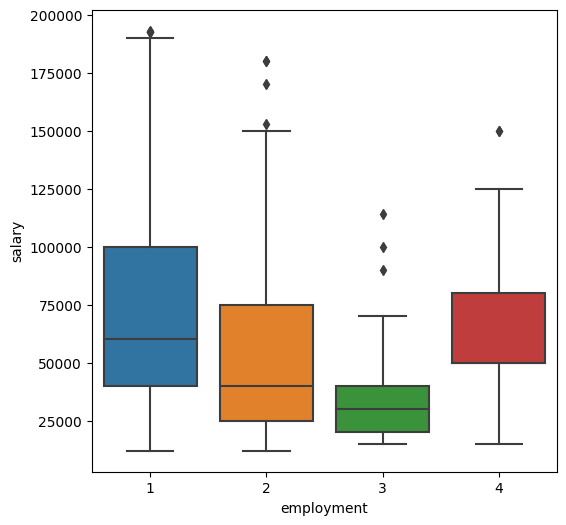

In [30]:
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x='employment', y='salary', data=df[df['salary']<200000])

In [31]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3137 non-null   int64  
 1   name                    3137 non-null   object 
 2   type                    3137 non-null   int64  
 3   area                    3137 non-null   object 
 4   salary                  3137 non-null   float64
 5   employer                3137 non-null   object 
 6   professional_roles      3137 non-null   object 
 7   experience              3137 non-null   int64  
 8   employment              3137 non-null   int64  
 9   snippet                 3137 non-null   object 
 10  area_new                3137 non-null   int64  
 11  professional_roles_new  3137 non-null   int64  
 12  employer_new            3137 non-null   int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 318.7+ KB


In [32]:
df1[['salary','experience']].corr() #корреляция Пирсона

,salary,experience
salary,1.000000,0.564717
experience,0.564717,1.000000


In [33]:
df1[['salary','experience']].corr(method='spearman') #корреляция Спирмена

,salary,experience
salary,1.000000,0.559858
experience,0.559858,1.000000


## Категориальные признаки

### Территория-профессия

In [34]:
WF=pd.crosstab(df1['area_new'],df1['professional_roles_new']) 
WF

professional_roles_new,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
area_new,,,,,,,,,,,,,,,
1,3,1,5,1,2,2,0,0,0,0,0,0,0,0,0
2,331,83,287,81,116,88,5,15,18,41,5,1,1,1,1
3,5,1,7,4,3,0,0,0,0,1,0,0,0,0,0
4,7,0,6,1,2,2,0,1,0,0,0,0,0,0,0
5,16,2,9,2,2,0,1,2,1,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
131,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
132,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
chi2, prob, f, expected = scipy.stats.chi2_contingency(WF)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, f, prob))

test Statistics: 1420.3465624820399
degrees of freedom: 1862
p-value: 0.9999999999999986



Зависимости между городом и профессией нет

### Профессия-занятость

In [36]:
tab=pd.crosstab(df1['professional_roles_new'],df1['employment']) 

In [37]:
chi2, prob, f, expected = scipy.stats.chi2_contingency(tab)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, f, prob))

test Statistics: 189.85947307025953
degrees of freedom: 42
p-value: 1.0857085374745315e-20



Связи между профессией и занятостью нет

### Профессия-работодатель

In [38]:
tab1=pd.crosstab(df1['professional_roles_new'],df1['employment'])
chi2, prob, f, expected = scipy.stats.chi2_contingency(tab1)
output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"
 
print(output.format( chi2, f, prob))

test Statistics: 189.85947307025953
degrees of freedom: 42
p-value: 1.0857085374745315e-20



# Регрессионный анализ

Парная регрессия

In [39]:
results1 = smf.ols('salary ~ experience', data=df).fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     1468.
Date:                Mon, 12 Jun 2023   Prob (F-statistic):          9.01e-264
Time:                        05:35:42   Log-Likelihood:                -38865.
No. Observations:                3137   AIC:                         7.773e+04
Df Residuals:                    3135   BIC:                         7.775e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.273e+04   1555.100     27.477      0.000    3.97e+04    4.58e+04
experience  3.232e+04    843.601     38.313      0.000    3.07e+04     3.4e+04
==============================================================================
Omnibus:                     1427.258   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13658.164
Skew:                           1.917   Prob(JB):                         0.00
Kurtosis:                      12.476   Cond. No.                         3.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3137 non-null   int64  
 1   name                3137 non-null   object 
 2   type                3137 non-null   int64  
 3   area                3137 non-null   object 
 4   salary              3137 non-null   float64
 5   employer            3137 non-null   object 
 6   professional_roles  3137 non-null   object 
 7   experience          3137 non-null   int64  
 8   employment          3137 non-null   int64  
 9   snippet             3137 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 245.2+ KB
